In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install kaggle

In [24]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file"{name}" with length(bytes)'.format(name = fn, length = len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file"kaggle.json" with length(bytes)


In [27]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [28]:
!chmod 600 ~/.kaggle/kaggle.json

In [31]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

100% 1.55G/1.56G [00:12<00:00, 125MB/s]
100% 1.56G/1.56G [00:12<00:00, 132MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 427kB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 134MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 104MB/s]


In [34]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


## 데이터 크기 확인

In [36]:
import os


def convert_bytes(file_path, unit=None):
    size = os.path.getsize(file_path)
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    elif unit == "GB":
        return print('File size: ' + str(round(size / (1024 * 1024 * 1024), 3)) + ' Gigabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')


file_list = ['train.csv',
             'test.csv',
             'sample_submission.csv']
for file in file_list:
  print("The {file} size: ".format(file=file))
  convert_bytes(file)
  convert_bytes(file, 'KB')
  convert_bytes(file, 'MB')
  convert_bytes(file, 'GB')
  print("--" * 5)


The train.csv size: 
File size: 5697178298 bytes
File size: 5563650.682 Kilobytes
File size: 5433.253 Megabytes
File size: 5.306 Gigabytes
----------
The test.csv size: 
File size: 983020 bytes
File size: 959.98 Kilobytes
File size: 0.937 Megabytes
File size: 0.001 Gigabytes
----------
The sample_submission.csv size: 
File size: 343271 bytes
File size: 335.226 Kilobytes
File size: 0.327 Megabytes
File size: 0.0 Gigabytes
----------


## 라이브러리 및 데이터 로드

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def skip_logic(index, skip_num):
    if index % skip_num == 0:
        return False
    return True


train = pd.read_csv('train.csv', skiprows=lambda x: skip_logic(x,
                    4), parse_dates=["pickup_datetime"])
print(train.shape)
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')


(13855964, 8)


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13855964 entries, 0 to 13855963
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 845.7+ MB


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


- 두 데이터를 비교해보면 Fare_Amount가 테스트 데이터에 없는 것을 확인할 수 있음
- 종속 변수로 추정

In [41]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
1,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1
2,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00+00:00,0.000000,0.000000,0.000000,0.000000,3
3,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,0.000000,0.000000,0.000000,0.000000,1
4,2014-12-06 20:36:22.0000008,4.0,2014-12-06 20:36:22+00:00,-73.979815,40.751902,-73.979446,40.755481,1


In [42]:
# Fare_Amount의 최댓값과 최솟값 구하기
print('Minimum Value of train:', train['fare_amount'].min())
print('Maximum Value of train:', train['fare_amount'].max())

Minimum Value of train: -300.0
Maximum Value of train: 93963.36


- -300이 나와 이해하기 어려워짐

In [43]:
print('Fare Amount<0:', sum(train['fare_amount']<0))
print('Fare Amount>0:', sum(train['fare_amount']>0))

Fare Amount<0: 610
Fare Amount>0: 13855007


In [44]:
from collections import Counter
Counter(train['fare_amount']<0)

Counter({False: 13855354, True: 610})

- 총 610개의 음수 데이터가 있는 것을 알 수 있음(삭제할 예정)

In [45]:
train = train.drop(train[train['fare_amount']<0].index, axis=0).reset_index(drop=True)
Counter(train['fare_amount']<0)

Counter({False: 13855354})

In [46]:
# 극단적인 데이터 제거
Counter(train['fare_amount']>500)

train = train.drop(train[train['fare_amount'] > 500].index,
                   axis=0).reset_index(drop=True)
print('Minimum Value of train:', train['fare_amount'].min())
print('Maximum Value of train:', train['fare_amount'].max())

Minimum Value of train: 0.0
Maximum Value of train: 500.0


 #### 데이터가 너무 크므로 층화 추출 샘플링을 사용해 표본의 크기를 줄임


In [47]:
train['passenger_count'].unique()

array([  1,   3,   6,   2,   5,   4,   0, 208, 129,  51,   8,   9])

- 0명인데 비용이 나온 것과 51명, 129명, 208명은 너무 많다 생각됨 
- 6명 이상과 0명은 삭제하는 것이 좋을 것으로 판단

In [48]:
train = train.drop(train[train['passenger_count']>6].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['passenger_count']==0].index, axis=0).reset_index(drop=True)
train['passenger_count'].unique()

array([1, 3, 6, 2, 5, 4])

In [49]:
# passenger_count의 비율 확인
train['passenger_count'].value_counts(normalize=True)

1    0.693959
2    0.148144
5    0.071225
3    0.044029
4    0.021383
6    0.021260
Name: passenger_count, dtype: float64

- 1명 탑승한 택시 승객의 비율이 약 70퍼에 해당하는 것을 확인

In [50]:
# StratifiedShuf-fleSplit 모듈을 사용해 층화 추출
from sklearn.model_selection import StratifiedShuffleSplit

sample = pd.DataFrame({'group': np.repeat(['A', 'B', 'C'], (60, 40, 20)),
                        'sample_value': np.random.randn(120)})
split = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)

for train_index, test_index in split.split(sample, sample['group']):
    strata_train_set = sample.loc[train_index]
    test_set = sample.loc[test_index]

print(sample['group'].value_counts(normalize=True))
print(sample.shape)
print(strata_train_set['group'].value_counts(normalize=True))
print(strata_train_set.shape)

A    0.500000
B    0.333333
C    0.166667
Name: group, dtype: float64
(120, 2)
A    0.500000
B    0.333333
C    0.166667
Name: group, dtype: float64
(36, 2)


- 위 결과값으로 변수 그룹 내 A, B, C이 동일한 비율로 표본이 추출된 것을 확인할 수 있음

In [51]:
# 본 데이터에 적용
split = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=42)

for large_index, sample_index in split.split(train, train['passenger_count']):
    large_df = train.loc[large_index]
    sample_df = train.loc[sample_index]

print('train:\n', train['passenger_count'].value_counts(normalize=True), train.shape)
print('sample:\n', sample_df['passenger_count'].value_counts(normalize=True), sample_df.shape)


train:
 1    0.693959
2    0.148144
5    0.071225
3    0.044029
4    0.021383
6    0.021260
Name: passenger_count, dtype: float64 (13806160, 8)
sample:
 1    0.693996
2    0.148113
5    0.071196
3    0.044036
4    0.021366
6    0.021294
Name: passenger_count, dtype: float64 (13807, 8)


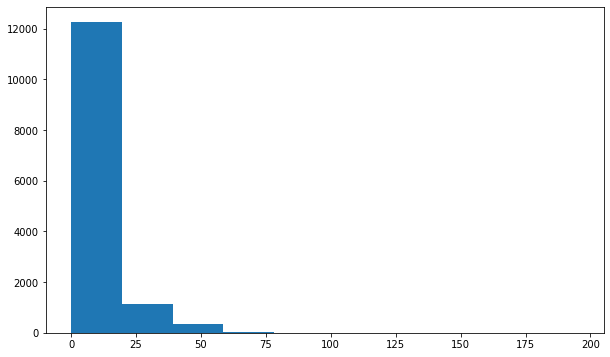

In [52]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(sample_df['fare_amount'])
plt.show()

#### 로그 변환
- 위도의 범위 -90 ~ 90
- 경도의 범위 -180 ~ 180
- 위 범위를 벗어나는 값이 있다면 제거

In [53]:
# 실제 데이터가 있는지 확인

Counter(train['pickup_latitude'] < -90) # -90보다 작은 데이터

Counter({False: 13806091, True: 69})

In [54]:
Counter(train['pickup_latitude'] > 90)  # 90보다 큰 데이터


Counter({False: 13805984, True: 176})

- -90보다 작은 데이터 69개와 90보다 큰 데이터 176개가 있는 것을 확인
- 위 데이터들을 삭제시킬겁니다.

In [55]:
train = train.drop(train[train['pickup_latitude'] < -90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_latitude'] > 90].index, axis=0).reset_index(drop=True)
Counter(train['pickup_latitude'] > 90)

Counter({False: 13805915})

In [56]:
train = train.drop(train[train['dropoff_latitude'] < -90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_latitude'] > 90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_longitude'] < -180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_longitude'] > 180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_latitude'] < -180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_latitude'] > 180].index, axis=0).reset_index(drop=True)
train.shape

(13805634, 8)

#### key, pickup_datetime이 날짜 데이터로 기록되는지 확인

In [57]:
# 우선 key 변수 확인
train.iloc[:3, 0]

0     2012-04-21 04:30:42.0000001
1    2012-01-04 17:22:00.00000081
2    2012-12-24 11:24:00.00000098
Name: key, dtype: object

In [58]:
train.iloc[:3, 2]

0   2012-04-21 04:30:42+00:00
1   2012-01-04 17:22:00+00:00
2   2012-12-24 11:24:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

#### 위도와 경도이 이상치를 제거한 후, 층화 추출을 활용해 sample 데이터만 추출하여 시각화 구현


In [59]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=42)

for large_index, sample_index in split.split(train, train['passenger_count']):
  large_df = train.loc[large_index]
  sample_df = train.loc[sample_index]


In [60]:
'''
함수는 필터링 기능을 사용
차량을 탑승한 위치의 위도와 경도, 하차한 위치의 위도와 경도를 표시
근데 표시한 지도 외에 데이터가 이상치로 존재하면 삭제하는 코드 (일종의 전처리 코드)
'''
Bounding_Box = (-74.5, -72.8, 40.5, 41.8)


def select_within_boundingbox(data, BB):
    return (data.pickup_longitude >= BB[0]) & (data.pickup_longitude <= BB[1]) & \
           (data.pickup_latitude >= BB[2]) & (data.pickup_latitude <= BB[3]) & \
           (data.dropoff_longitude >= BB[0]) & (data.dropoff_longitude <= BB[1]) & \
           (data.dropoff_latitude >= BB[2]) & (data.dropoff_latitude <= BB[3])


print('Old size: %d' % len(sample_df))
sample_df = sample_df[select_within_boundingbox(sample_df, Bounding_Box)]
print('New size: %d' % len(sample_df))


Old size: 13806
New size: 13495


In [61]:
print('Old size: %d'%len(sample_df))
sample_df = sample_df[select_within_boundingbox(sample_df, Bounding_Box)]
print('New size: %d'%len(sample_df))

Old size: 13495
New size: 13495


### 뉴욕 지도 시각화

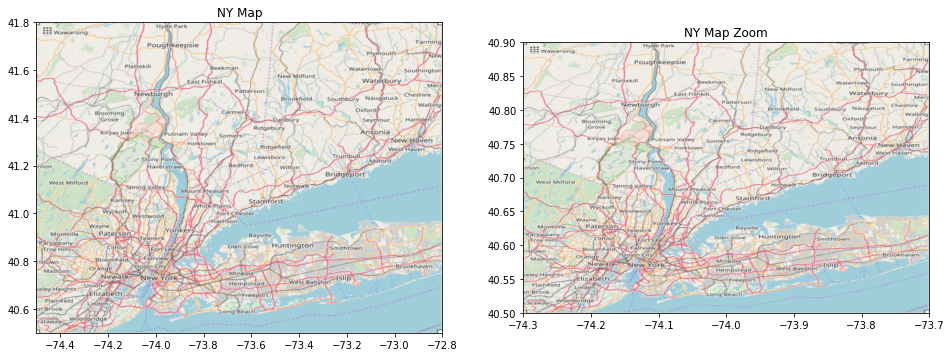

In [63]:
#뉴욕의 지도만 출력
import ssl
from urllib.request import urlopen
context = ssl._create_unverified_context()

#load image of NYC map
Bounding_Box = (-74.5, -72.8, 40.5, 41.8)
NYC_MAP_img_path = 'https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png'
NYC_MAP = urlopen(NYC_MAP_img_path, context=context)
nyc_map = plt.imread(NYC_MAP)

#load extra image to zoom in on NYC
Bounding_Box_Zoom = (-74.3, -73.7, 40.5, 40.9)
NYC_MAP_ZOOM_img_path = 'https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png'
NYC_MAP_ZOOM = urlopen(NYC_MAP_img_path, context=context)
nyc_map_zoom = plt.imread(NYC_MAP_ZOOM)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(nyc_map, zorder=0, extent=Bounding_Box)
ax[0].set_title("NY Map")

ax[1].imshow(nyc_map_zoom, zorder=0, extent=Bounding_Box_Zoom)
ax[1].set_title("NY Map Zoom")

plt.show()


In [64]:
# 산점도
def scatter_plot_on_map(df, Bounding_Box, nyc_map, s=10, alpha=0.2):
    fig, ax = plt.subplots(1, 2, figsize=(16,10))
    ax[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[0].set_xlim((Bounding_Box[0], Bounding_Box[1]))
    ax[0].set_ylim((Bounding_Box[2], Bounding_Box[3]))
    ax[0].set_title('Pickup locations')
    ax[0].imshow(nyc_map, zorder=0, extent=Bounding_Box)

    ax[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax[1].set_xlim((Bounding_Box[0], Bounding_Box[1]))
    ax[1].set_ylim((Bounding_Box[2], Bounding_Box[3]))
    ax[1].set_title('Dropoff locations')
    ax[1].imshow(nyc_map, zorder=0, extent=Bounding_Box)

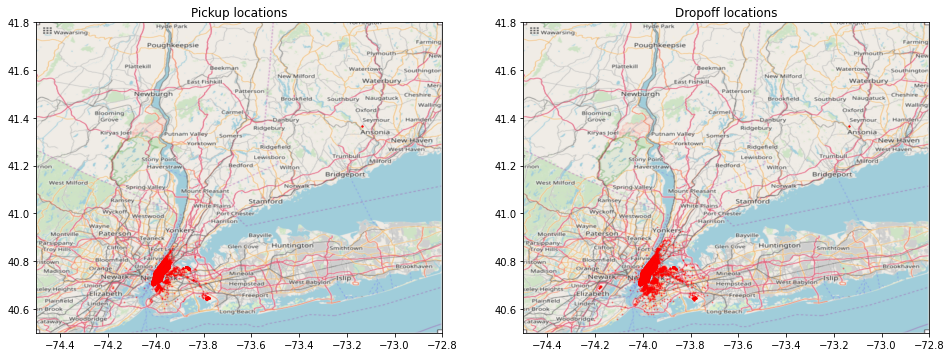

In [65]:
# 승하차 위치 산점도 시각화 1
scatter_plot_on_map(sample_df, Bounding_Box, nyc_map, s=1, alpha=0.3)

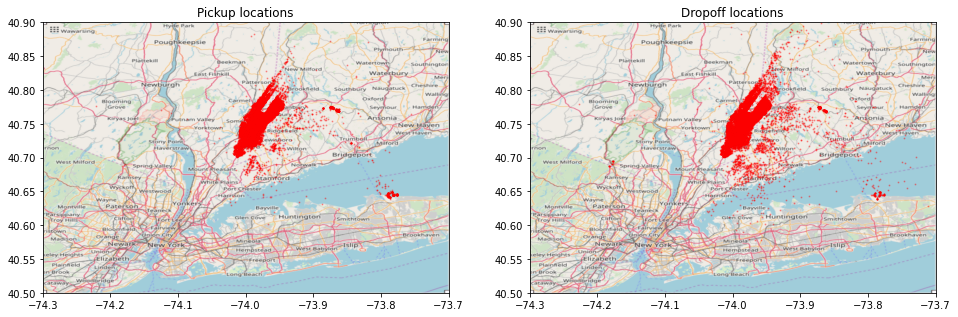

In [66]:
# 승하차 위치 산점도 시각화 2
scatter_plot_on_map(sample_df, Bounding_Box_Zoom, nyc_map_zoom, s=1, alpha=0.3)

In [68]:
# 날짜 변동 확인
sample_df['Year'] = sample_df['pickup_datetime'].dt.year
sample_df['Month'] = sample_df['pickup_datetime'].dt.month
sample_df['Date'] = sample_df['pickup_datetime'].dt.day
sample_df['Day of Week'] = sample_df['pickup_datetime'].dt.dayofweek
sample_df['Hour'] = sample_df['pickup_datetime'].dt.hour
print(sample_df.iloc[:, 8:])

          Year  Month  Date  Day of Week  Hour
11530824  2010      5     3            0    21
7405179   2009     10    13            1    17
13222494  2011      5    13            4     7
6400875   2013      9    28            5     4
9764108   2014      4     4            4    15
...        ...    ...   ...          ...   ...
10518363  2010      5     6            3     7
9965118   2011      9     6            1    21
13284221  2013     10    22            1    13
6248642   2012      2    23            3    18
11454230  2014      2     1            5     9

[13495 rows x 5 columns]


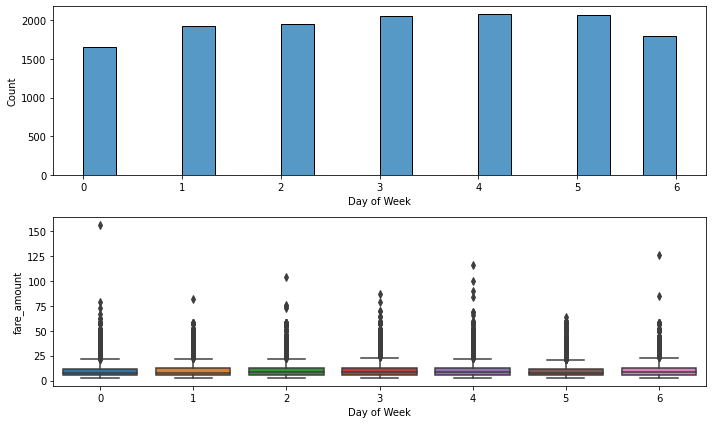

In [69]:
# 날짜별 운임료 시각화
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 6))
sns.histplot(sample_df['Day of Week'], ax=ax[0])
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Count')

sns.boxplot(x = 'Day of Week', y = 'fare_amount', data=sample_df, ax=ax[1])
ax[1].set_xlabel('Day of Week')

fig.tight_layout()
plt.show()

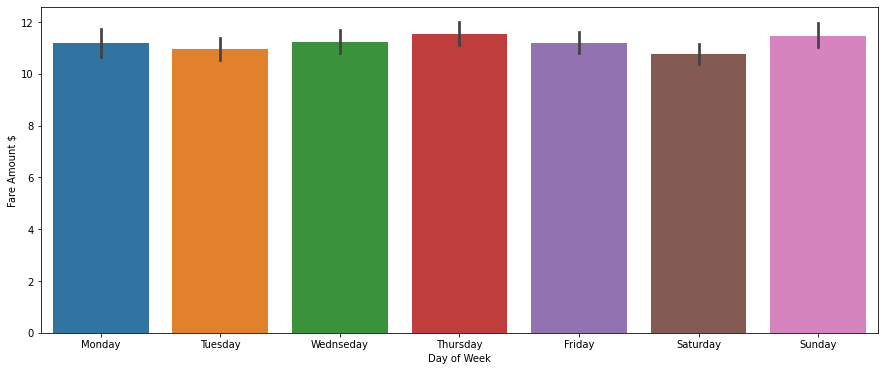

In [71]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x = 'Day of Week', y = 'fare_amount', data=sample_df)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Fare Amount $')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednseday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

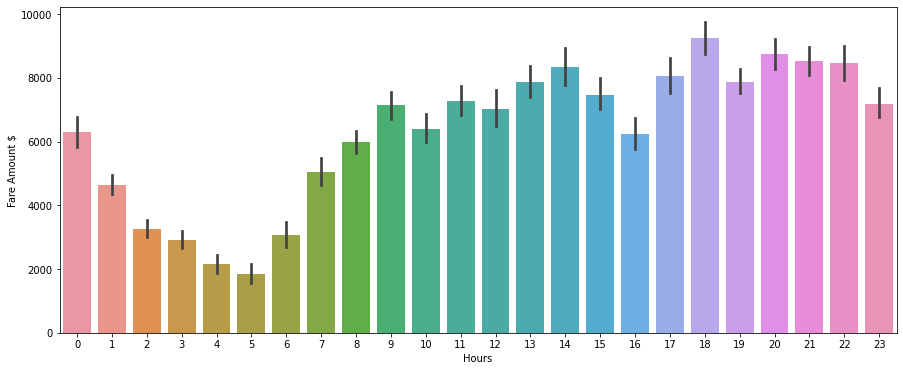

In [70]:
# 시간대별 운임료 시각화
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x = 'Hour', y = 'fare_amount', data=sample_df, estimator=sum)
ax.set_xlabel('Hours')
ax.set_ylabel('Fare Amount $')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x = 'Day of Week', y = 'fare_amount', data=sample_df)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Fare Amount $')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednseday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

## 피처 엔지니어링

- 데이터의 크기가 너무 크므로 줄여서 작업

In [72]:
def skip_logic(index, skip_num):
    if index % skip_num == 0:
        return False
    return True

train = pd.read_csv('./train.csv', skiprows=lambda x: skip_logic(x, 1000))
print(train.shape)
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

(55423, 8)


In [73]:
# 경도의 최솟값과 최댓값
print("Longitude Boundary in test")
print("Minimum Value of Longitude:", min(test.pickup_longitude.min(), test.dropoff_longitude.min()))
print("Maximum Value of Longitude:", max(test.pickup_longitude.max(), test.dropoff_longitude.max()))

Longitude Boundary in test
Minimum Value of Longitude: -74.263242
Maximum Value of Longitude: -72.986532


In [74]:
# 위도의 최솟값과 최댓값
print("Latitude Boundary in test")
print("Minimum Value of Latitude:", min(test.pickup_latitude.min(), test.pickup_latitude.min()))
print("Maximum Value of Latitude:", max(test.pickup_latitude.max(), test.pickup_latitude.max()))

Latitude Boundary in test
Minimum Value of Latitude: 40.573143
Maximum Value of Latitude: 41.709555


### Boundary 딕셔너리의 개별 값으로 입력

In [75]:
def preprocssing(data):
  print("Old Shape Size:", data.shape)  

  # Remove Missing Value
  data = data.drop(data[data.isnull().any(1)].index, axis = 0)

  # Removing Outliers
  if 'fare_amount' in data.columns:
    data = data.drop(data[data['fare_amount'] < 0].index, axis=0).reset_index(drop=True)
    data = data.drop(data[data['fare_amount'] > 500].index, axis=0).reset_index(drop=True)

    # Removing Beyond NYC
    # 1 is beyond NY, so will delete
    boundary={'min_lng':-74.263242,'min_lat':40.573143,'max_lng':-72.986532, 'max_lat':41.709555}
    data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_beyond_NY']=1

    data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_beyond_NY']=0
    print("Outlier vs Non Outlier Counts")
    print(data['is_beyond_NY'].value_counts())
    # print(data[data['is_beyond_NY'] == 1.0].head())
    data = data.drop(data[data['is_beyond_NY']== 1.0].index, axis=0).reset_index(drop=True)
    data.drop(['is_beyond_NY'], axis=1, inplace=True)
  
  data = data.drop(data[data['passenger_count'] > 6].index, axis=0).reset_index(drop=True)
  data = data.drop(data[data['passenger_count'] == 0].index, axis=0).reset_index(drop=True)
  data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

  # new variables from pickup_datetime
  data['year'] = data['pickup_datetime'].dt.year
  data['month'] = data['pickup_datetime'].dt.month
  data['date'] = data['pickup_datetime'].dt.day
  data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
  data['hour'] = data['pickup_datetime'].dt.hour
  
  # Delete Some Variables
  data.drop(['key','pickup_datetime'], axis=1, inplace=True)

  print("New Shape Size:", data.shape)
  return data

In [76]:
# 전처리 이후 데이터 요약
new_train = preprocssing(train)
new_train

Old Shape Size: (55423, 8)
Outlier vs Non Outlier Counts
0.0    54190
1.0     1230
Name: is_beyond_NY, dtype: int64
New Shape Size: (53997, 11)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day_of_week,hour
0,10.9,-73.988455,40.758432,-73.983816,40.730147,1,2012,5,18,4,18
1,7.5,-73.991776,40.726189,-73.987656,40.739204,5,2015,2,1,6,2
2,56.8,-73.988152,40.740112,-73.782355,40.646727,2,2012,10,23,1,7
3,14.5,-73.984455,40.759038,-74.011728,40.707793,2,2010,7,31,5,22
4,13.3,-73.983301,40.743722,-73.964523,40.710758,1,2011,2,28,0,18
...,...,...,...,...,...,...,...,...,...,...,...
53992,10.5,-73.984875,40.729762,-74.001793,40.746700,1,2013,2,3,6,22
53993,17.5,-73.984185,40.749052,-73.911797,40.761047,1,2012,12,22,5,3
53994,8.5,-73.971578,40.755180,-73.978423,40.751367,1,2013,10,14,0,8
53995,14.9,-73.999957,40.678620,-74.007187,40.728660,1,2009,8,5,2,7


## 하버사인

In [77]:
!pip install haversine

In [78]:
# 서울과 부산의 직선거리 구하기
from haversine import haversine, Unit
seoul = (37.532600, 127.024612)
busan = (35.114839, 129.041494)

haversine(seoul, busan)

323.89975226124534

In [79]:
# Haversine 함수에 Pandas 각각의 변수를 List로 변환한 후 각 리스트 인덱스 값을 반복문에 적용해 하나씩 계산
distances = []
pick_lon = new_train['pickup_longitude'].tolist()
pick_lat = new_train['pickup_latitude'].tolist()
drop_lon = new_train['dropoff_longitude'].tolist()
drop_lat = new_train['dropoff_latitude'].tolist()

for row in range(len(new_train)):
  dist = haversine((pick_lat[row], pick_lon[row]), (drop_lat[row], drop_lon[row]))
  distances.append(dist)

new_train['distance'] = distances
print(new_train[['fare_amount', 'distance', 'passenger_count']])

       fare_amount   distance  passenger_count
0             10.9   3.169341                1
1              7.5   1.488336                5
2             56.8  20.220492                2
3             14.5   6.144112                2
4             13.3   3.992399                1
...            ...        ...              ...
53992         10.5   2.361989                1
53993         17.5   6.241498                1
53994          8.5   0.715686                1
53995         14.9   5.597480                1
53996          8.0   1.118084                1

[53997 rows x 3 columns]


- 도로의 거리가 아닌 직선거리를 의미
- 좌표의 거리를 구했기에 위도와 경도 등은 모두 삭제

In [80]:
new_train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

In [81]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53997 entries, 0 to 53996
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fare_amount      53997 non-null  float64
 1   passenger_count  53997 non-null  int64  
 2   year             53997 non-null  int64  
 3   month            53997 non-null  int64  
 4   date             53997 non-null  int64  
 5   day_of_week      53997 non-null  int64  
 6   hour             53997 non-null  int64  
 7   distance         53997 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 3.3 MB


## CV 및 Grid Search

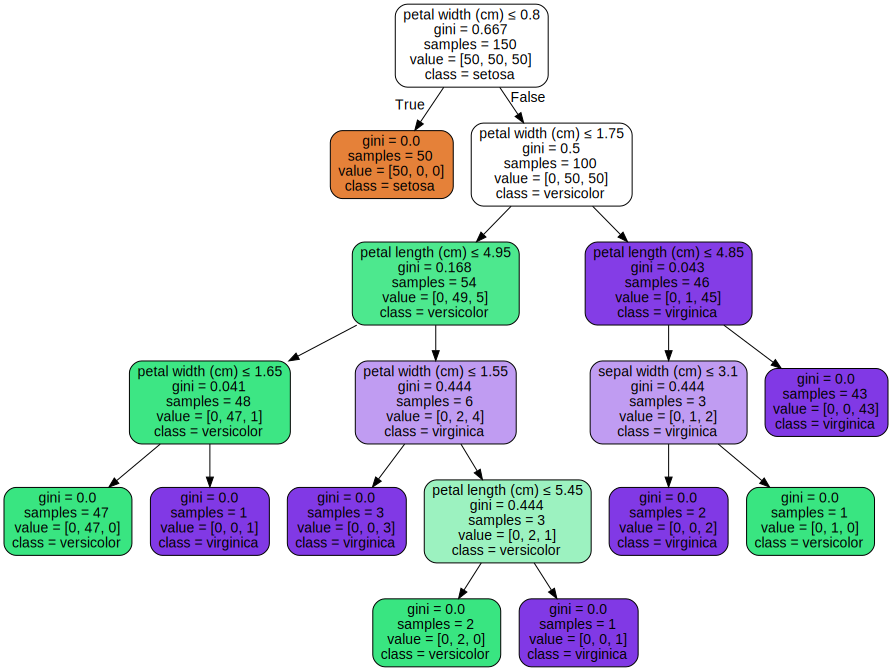

In [82]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
iris = load_iris()
X_features = iris.data
y_target = iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_features, y_target)
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)
graph
# graph.render("iris")

In [83]:
print(clf)

DecisionTreeClassifier()


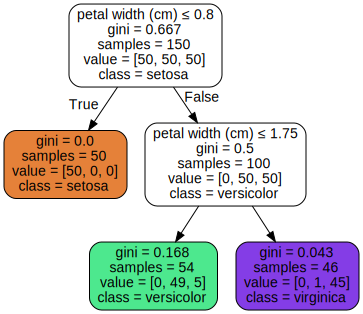

In [84]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_features, y_target)
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)
graph
# graph.render("iris")

In [85]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, 
                                                    test_size=0.2, random_state=42)

tree = DecisionTreeClassifier()

grid_search_params = {'max_depth': [1, 2], 
                     'max_features': [1, 2]}

grid_tree = GridSearchCV(tree, param_grid=grid_search_params, cv = 5)
grid_tree.fit(X_train, y_train)

scores = pd.DataFrame(grid_tree.cv_results_)
scores[['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 1, 'max_features': 1}",0.633333,4
1,"{'max_depth': 1, 'max_features': 2}",0.675000,3
2,"{'max_depth': 2, 'max_features': 1}",0.825000,2
3,"{'max_depth': 2, 'max_features': 2}",0.933333,1


In [86]:
from scipy.stats import randint
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, 
                                                    test_size=0.2, random_state=42)

tree = DecisionTreeClassifier()

random_search_params = {'max_depth': randint(1, 5), 
                     'max_features': randint(1, 4)}

random_tree = RandomizedSearchCV(tree, random_search_params, cv = 5)
random_tree.fit(X_train, y_train)

scores = pd.DataFrame(random_tree.cv_results_)
scores[['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 4, 'max_features': 1}",0.891667,3
1,"{'max_depth': 4, 'max_features': 3}",0.950000,1
2,"{'max_depth': 2, 'max_features': 1}",0.775000,7
3,"{'max_depth': 1, 'max_features': 3}",0.675000,9
4,"{'max_depth': 3, 'max_features': 2}",0.933333,2
5,"{'max_depth': 2, 'max_features': 1}",0.766667,8
6,"{'max_depth': 2, 'max_features': 1}",0.875000,4
7,"{'max_depth': 2, 'max_features': 2}",0.858333,5
8,"{'max_depth': 2, 'max_features': 1}",0.841667,6
9,"{'max_depth': 1, 'max_features': 2}",0.666667,10


## 모델링

In [87]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from math import sqrt
import time
import datetime 

In [88]:
y = new_train['fare_amount']
new_train.drop(['fare_amount'], axis=1, inplace=True)
X = new_train
X.shape, y.shape

((53997, 7), (53997,))

In [89]:
# XGboost
new_test = preprocssing(test)

distances = []
pick_lon = new_test['pickup_longitude'].tolist()
pick_lat = new_test['pickup_latitude'].tolist()
drop_lon = new_test['dropoff_longitude'].tolist()
drop_lat = new_test['dropoff_latitude'].tolist()

for row in range(len(new_test)):
  dist = haversine((pick_lat[row], pick_lon[row]), (drop_lat[row], drop_lon[row]))
  distances.append(dist)

new_test['distance'] = distances
new_test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

Old Shape Size: (9914, 7)
New Shape Size: (9914, 10)


In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((43197, 7), (10800, 7), (43197,), (10800,))

In [91]:
params = {'max_depth':5,
          'learning_rate':0.5,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'early_stopping_rounds':5
         }
      
xgb_model = xgb.XGBRegressor(**params)
print(xgb_model)
start = time.time()

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

sec = time.time() - start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(times)

XGBRegressor(early_stopping_rounds=5, eval_metric='rmse', learning_rate=0.5,
             max_depth=5)
[11:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.19605
[1]	validation_0-rmse:5.4949
[2]	validation_0-rmse:4.56644
[3]	validation_0-rmse:4.28582
[4]	validation_0-rmse:4.24593
[5]	validation_0-rmse:4.25462
[6]	validation_0-rmse:4.26433
[7]	validation_0-rmse:4.27621
[8]	validation_0-rmse:4.30134
[9]	validation_0-rmse:4.27762
[10]	validation_0-rmse:4.2712
[11]	validation_0-rmse:4.26525
[12]	validation_0-rmse:4.26052
[13]	validation_0-rmse:4.25105
[14]	validation_0-rmse:4.27252
[15]	validation_0-rmse:4.27278
[16]	validation_0-rmse:4.26572
[17]	validation_0-rmse:4.26369
[18]	validation_0-rmse:4.26464
[19]	validation_0-rmse:4.27677
[20]	validation_0-rmse:4.28204
[21]	validation_0-rmse:4.29514
[22]	validation_0-rmse:4.29446
[23]	validation_0-rmse:4.29948
[24]	validation_0-rmse:4.29533
[25]	va

In [92]:
# 예측값 뽑기
y_pred_xgb = xgb_model.predict(new_test)
print(y_pred_xgb)

[10.515442  10.8846245  4.544116  ... 60.49668   25.85212    6.05947  ]


In [93]:
submission['fare_amount'] = y_pred_xgb
submission.to_csv('final_220105_submission.csv', index=False)

In [94]:
# 제출
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f final_220105_submission.csv -m "Message"

100% 370k/370k [00:01<00:00, 257kB/s]
Successfully submitted to New York City Taxi Fare Prediction

## LightGBM

In [95]:
params = {'max_depth':5,
          'learning_rate':0.5,
          'objective':'regression',
          'metric':'rmse',
          'early_stopping_rounds':5
         }

start = time.time()
lgb_model = lgb.LGBMRegressor(**params)
print(lgb_model)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

sec = time.time() - start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(times)

y_pred_lgb = lgb_model.predict(new_test)
print(y_pred_xgb)

submission['fare_amount'] = y_pred_lgb
submission.to_csv('lightgbm_final_submission.csv', index=False)

LGBMRegressor(early_stopping_rounds=5, learning_rate=0.5, max_depth=5,
              metric='rmse', objective='regression')
[1]	valid_0's rmse: 6.13213
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 4.80094
[3]	valid_0's rmse: 4.3899
[4]	valid_0's rmse: 4.26092
[5]	valid_0's rmse: 4.21729
[6]	valid_0's rmse: 4.21778
[7]	valid_0's rmse: 4.21239
[8]	valid_0's rmse: 4.23947
[9]	valid_0's rmse: 4.25212
[10]	valid_0's rmse: 4.25856
[11]	valid_0's rmse: 4.2604
[12]	valid_0's rmse: 4.28108
Early stopping, best iteration is:
[7]	valid_0's rmse: 4.21239
0:00:00
[10.515442  10.8846245  4.544116  ... 60.49668   25.85212    6.05947  ]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [96]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f lightgbm_final_submission.csv -m "Message"

100% 454k/454k [00:01<00:00, 249kB/s]
Successfully submitted to New York City Taxi Fare Prediction

## CatBoost


In [97]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [103]:
from catboost import CatBoostRegressor
params = {'depth':5,
          'learning_rate':0.5,
          'eval_metric':'RMSE',
          'early_stopping_rounds':2
         }

start = time.time()
cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=True)

sec = time.time() - start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(times)

y_pred_cat = cat_model.predict(new_test)
print(y_pred_cat)


0:	learn: 6.5270465	test: 6.4783004	best: 6.4783004 (0)	total: 11.1ms	remaining: 11.1s
1:	learn: 5.2689682	test: 5.0919990	best: 5.0919990 (1)	total: 25.1ms	remaining: 12.5s
2:	learn: 4.7986472	test: 4.6333005	best: 4.6333005 (2)	total: 31.4ms	remaining: 10.4s
3:	learn: 4.5979235	test: 4.4403268	best: 4.4403268 (3)	total: 37.4ms	remaining: 9.31s
4:	learn: 4.4924420	test: 4.3327791	best: 4.3327791 (4)	total: 43.3ms	remaining: 8.62s
5:	learn: 4.4326904	test: 4.3061620	best: 4.3061620 (5)	total: 49.1ms	remaining: 8.14s
6:	learn: 4.4058228	test: 4.3009413	best: 4.3009413 (6)	total: 54.6ms	remaining: 7.74s
7:	learn: 4.3792239	test: 4.3005755	best: 4.3005755 (7)	total: 59.9ms	remaining: 7.43s
8:	learn: 4.3668696	test: 4.3181492	best: 4.3005755 (7)	total: 65.3ms	remaining: 7.19s
9:	learn: 4.3374818	test: 4.2843097	best: 4.2843097 (9)	total: 70.9ms	remaining: 7.02s
10:	learn: 4.3170002	test: 4.2842661	best: 4.2842661 (10)	total: 76.5ms	remaining: 6.88s
11:	learn: 4.3080276	test: 4.2851028	best

In [104]:
submission['fare_amount'] = y_pred_xgb
submission.to_csv('catboost_final_0105_submission.csv', index=False)

In [105]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f catboost_final_0105_submission.csv -m "Message"

100% 370k/370k [00:01<00:00, 220kB/s]
Successfully submitted to New York City Taxi Fare Prediction

In [106]:
ensembled_prediction = (0.3 * y_pred_xgb) + (0.4 * y_pred_lgb) + (0.3 * y_pred_cat)

submission.to_csv('ensembled_final_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.515442
1,2015-01-27 13:08:24.0000003,10.884624
2,2011-10-08 11:53:44.0000002,4.544116
3,2012-12-01 21:12:12.0000002,8.347191
4,2012-12-01 21:12:12.0000003,16.932850
5,2012-12-01 21:12:12.0000005,11.803183
6,2011-10-06 12:10:20.0000001,5.735718
7,2011-10-06 12:10:20.0000003,51.927792
8,2011-10-06 12:10:20.0000002,12.292977
9,2014-02-18 15:22:20.0000002,7.252489


In [107]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f ensembled_final_submission.csv -m "Message"

100% 370k/370k [00:01<00:00, 220kB/s]
Successfully submitted to New York City Taxi Fare Prediction